<a href="https://colab.research.google.com/github/manufabregas/Dataset-Asistencia-a-turnos-m-dicos/blob/main/v2_Incluyo_Test_Funcionando_Detecci%C3%B3n_del_Sarcasmo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Domingo 20 de Octubre 23:59**

ALTERNATIVA 1: Redes Recurrentes, Transformers, LLMs

Dado el dataset que busca detectar si una oración es sarcástica o no. Se pide:


1.   Preprocesar los datos de texto teniendo en cuenta como baseline lo que se hizo en esta notebook.  Tengan cuenta evaluar cual es la longitud máxima de sus sentencias o qué les conviene agregar/sacar para procesar el dataset de sarcasmo así como otras variables que pueden ser propias del problema y/o dataset.


2. Implementar una red neuronal RNN simple con capas lstm (este será su baseline).


3. Implementar 2 modelos adicionales de redes para problemas de NLP teniendo en cuenta lo siguiente:


Realizando una búsqueda de hiperparametros buscando mejorar el baseline. Traten de centrarse en probar 2, como mucho 3, hiperparametros y ver los cambios en base a esos hiperparametros porque sino las pruebas se hacen infinitas. La idea es que prueben: Diferentes tamaños de épocas, Tamaño de batch, Cantidad de capas lstm, valor de dropout, etc.

Implementando otras arquitecturas de redes recurrentes con capas con RNN o  GRU

Incorporando transformers (ej. Bert)  o el uso de LLMs

4. Mostrar e Interpretar los resultados usando las curvas de aprendizaje.

#Importaremos las librerías que utilizaremos a lo largo de la noteboooks

---



In [1]:
# Librerías estándar de Python
import gzip
import re
import string
from collections import Counter
from string import punctuation
from typing import Tuple, Dict


# Librerías de terceros
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm, trange
from wordcloud import WordCloud,STOPWORDS


# Librerías de PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

#Librería para cargar y transformar el archivo json
from google.colab import files
import json
import ast


# Configuración de pandas
pd.set_option("display.max_colwidth", 120)

# Seteamos la semilla
seed = 14
torch.manual_seed(seed)
np.random.seed(seed)
# Si utilizas CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [2]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#Cargamos el dataset propuesto: Sarcasm_Headlines_Dataset

---

In [3]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving Sarcasm_Headlines_Dataset.json to Sarcasm_Headlines_Dataset.json


In [4]:
# transformamos el archivo json
data = []
with open('Sarcasm_Headlines_Dataset.json', 'r') as f:
    for line in f:
        try:
            entry = ast.literal_eval(line.strip())
            data.append(entry)
        except ValueError as e:
            print(f"Error en la línea: {line}")
            print(f"Detalles del error: {e}")

# Creamos el DataFrame
df = pd.DataFrame(data)
print(df.info()) #Verificamos si tenemos valores nulos
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB
None


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5,former versace store clerk sues over secret 'black code' for minority shoppers,0
1,https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0
2,https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697,mom starting to fear son's web series closest thing she will have to grandchild,1
3,https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1
4,https://www.huffingtonpost.com/entry/jk-rowling-wishes-snape-happy-birthday_us_569117c4e4b0cad15e64fdcb,j.k. rowling wishes snape happy birthday in the most magical way,0


Podemos observar que tenemos 3 columnas: una con el link de la noticia, otra el título y por último neustra variable "target" que define si el título de la noticia es o no sarcástica

#Analizaremos las palabras que más se repiten. Primero para los healines que no son sarcásticos y luego para los que sí lo son.

---

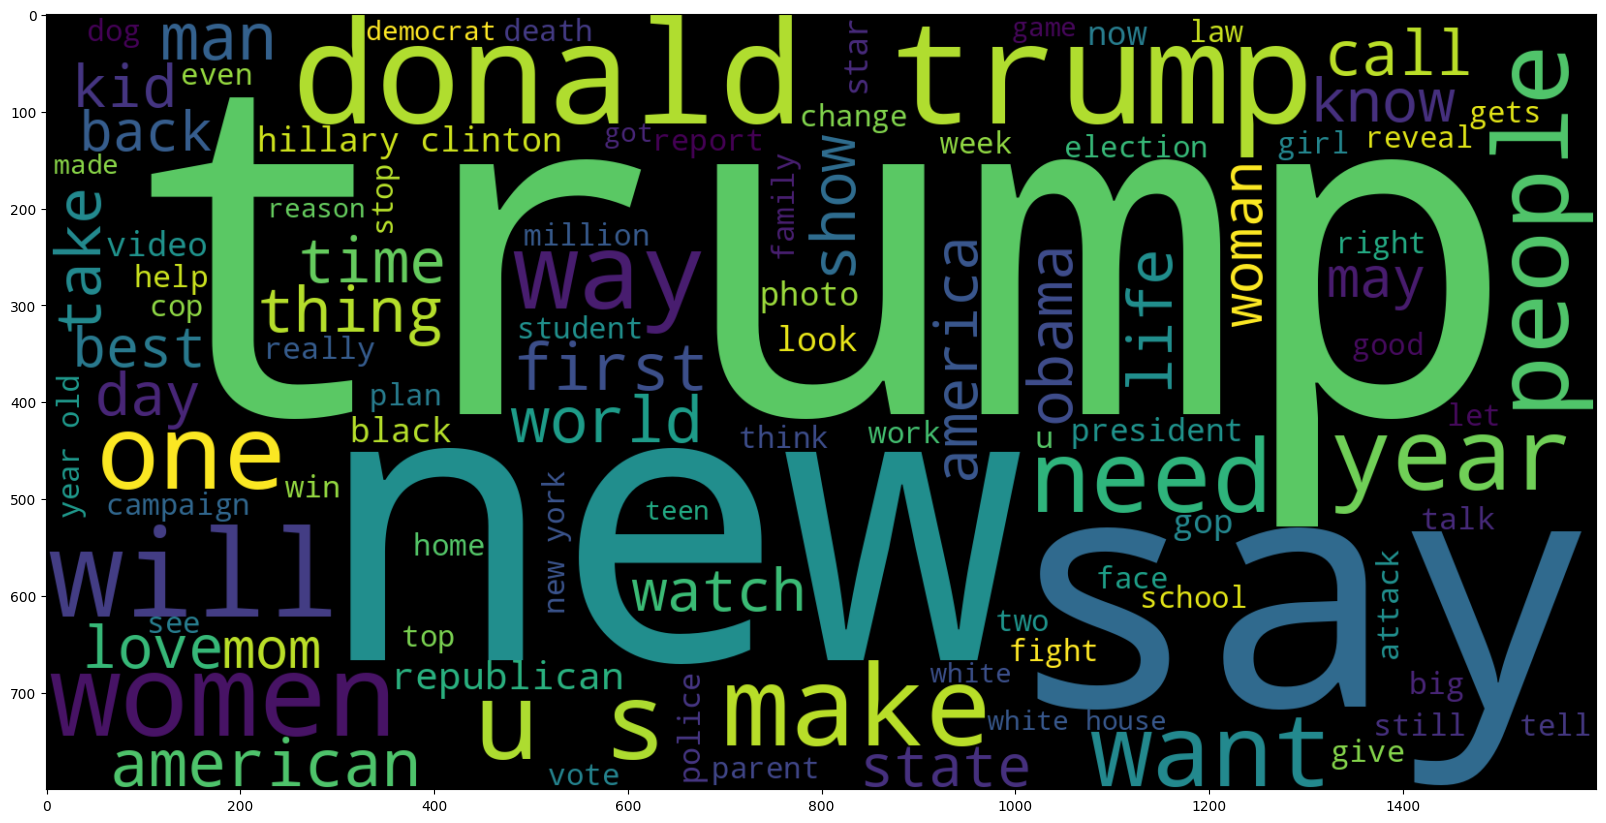

In [5]:
#WordCloud de palabras cuando NO es sarcástico
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 100 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

Se observa que como principales palabras figuran todas palabras en inglés relacionadas con Estados Unidos y Donald Trump.

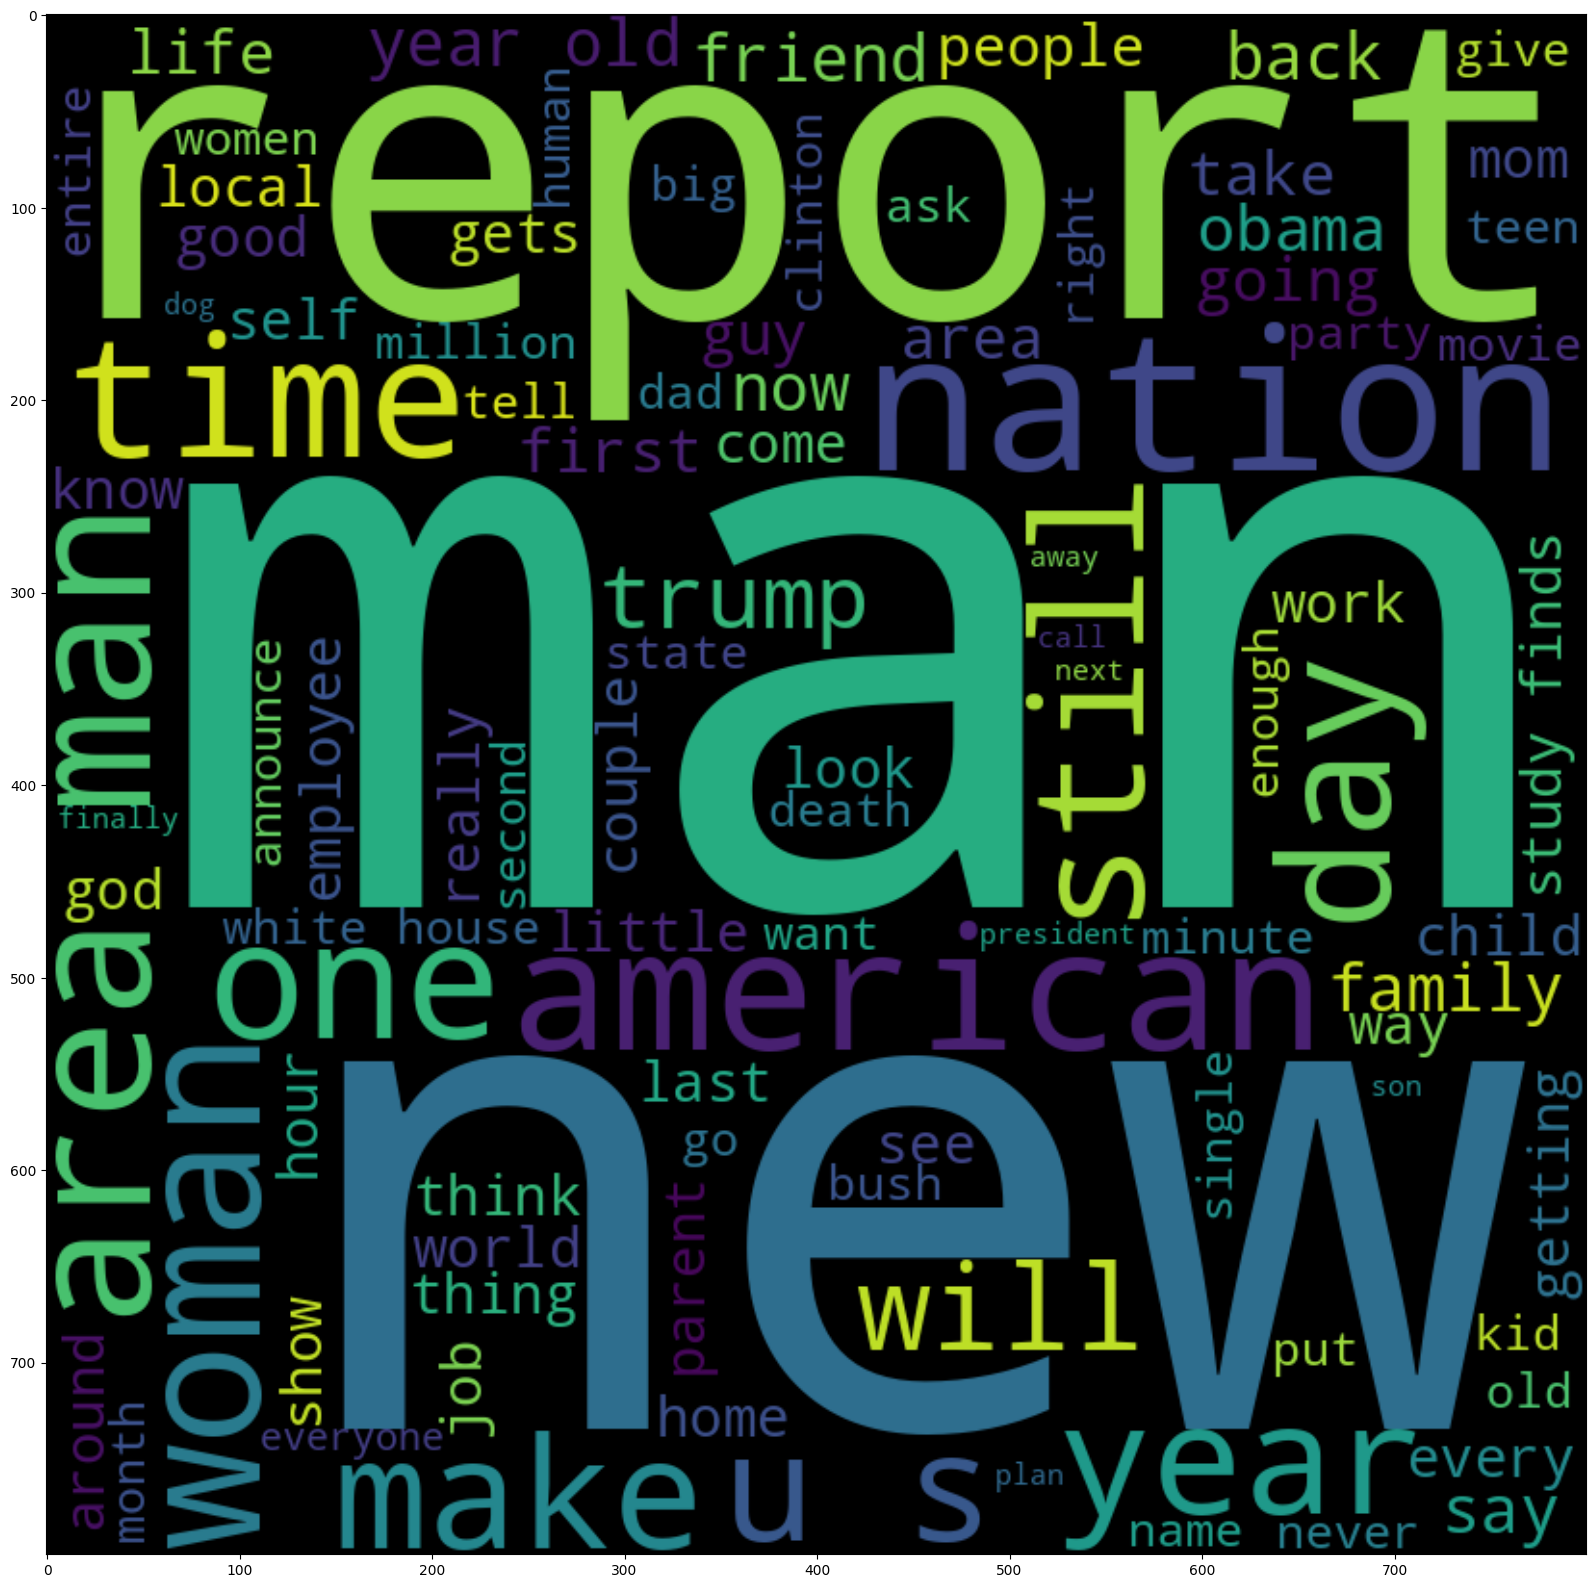

In [6]:
#WordCloud de palabras cuando ES sarcástico
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 100 , width = 800 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

Con respecto a los headlines que son sarcásticos, observamos que las palabras traducidas hombre , nuevo y reporte son las que más se repiten

# 1. **Preprocesar los datos de texto teniendo en cuenta como baseline lo que se hizo en esta notebook. Tengan cuenta evaluar cual es la longitud máxima de sus sentencias o qué les conviene agregar/sacar para procesar el dataset de sarcasmo así como otras variables que pueden ser propias del problema y/o dataset.**


---




In [7]:
# Visualizamos una descripción aleatoria de headline
random_row = np.random.randint(0, len(df))
df.iloc[random_row]['headline']

"kushner doesn't want to give up his security clearance as john kelly cracks down: report"

In [8]:
#Chequeamos que no haya filas duplicadas
df_check=df.duplicated().sum()
print(df.shape)
print(df_check)
duplicated_rows = df[df.duplicated()]
duplicated_rows

(26709, 3)
1


,article_link,headline,is_sarcastic
22014,https://www.huffingtonpost.comhttp://nymag.com/daily/intelligencer/2016/05/hillary-clinton-candidacy.html,hillary clinton vs. herself,0


In [9]:
#Comprobamos de que existe un valor duplicado
df_check=df.copy()
df_check= df_check[df_check['headline']=='hillary clinton vs. herself']
df_check

,article_link,headline,is_sarcastic
2122,https://www.huffingtonpost.comhttp://nymag.com/daily/intelligencer/2016/05/hillary-clinton-candidacy.html,hillary clinton vs. herself,0
22014,https://www.huffingtonpost.comhttp://nymag.com/daily/intelligencer/2016/05/hillary-clinton-candidacy.html,hillary clinton vs. herself,0


Encontramos que tenemos un solo headline del dataset que se encuentra duplicado

In [10]:
#Eliminamos las filas duplicadas
df = df.drop_duplicates()
print(df.shape)

(26708, 3)


Eliminamos dicho registro duplicado ya que no agrega valor tenerlo duplicado. En caso de que fuera más, tendría más sentido eliminar estos registros ya que implicaría un costo computacional.

In [11]:
#Realizaremos un análisis adicional de la cantidad de palabras de cada headline
df['word_count'] = df['headline'].apply(lambda x: len(x.split()))
df.head()

,article_link,headline,is_sarcastic,word_count
0,https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5,former versace store clerk sues over secret 'black code' for minority shoppers,0,12
1,https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0,14
2,https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697,mom starting to fear son's web series closest thing she will have to grandchild,1,14
3,https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1,13
4,https://www.huffingtonpost.com/entry/jk-rowling-wishes-snape-happy-birthday_us_569117c4e4b0cad15e64fdcb,j.k. rowling wishes snape happy birthday in the most magical way,0,11


In [71]:
df_check=df.copy()
df_check= df_check[df_check['word_count']<=1]
df_check

,article_link,headline,is_sarcastic,word_count


En este caso queríamos observar si existían títulos con una sola palabra, ya que esto podría generar sesgo en la clasificación de los títulos, pero no se encontraron observaciones.

# **Separamos el dataset en entrenamiento, validación y test**

---



In [12]:
# Dividir el conjunto de datos en conjuntos en train y test
X = df['headline'].values
y = df['is_sarcastic'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=seed)

print(f'Cantidad de datos en train: {X_train.shape[0]}')
print(f'Cantidad de datos en val: {X_val.shape[0]}')
print(f'Cantidad de datos en test: {X_test.shape[0]}')
print('-------------------------------')

print('XTrain')
print(X_train)
print('Ytrain')
print(y_train)


Cantidad de datos en train: 18695
Cantidad de datos en val: 5609
Cantidad de datos en test: 2404
-------------------------------
XTrain
["report: trump bans 'transgender,' 'fetus,' 'science-based' from cdc documents"
 'do you suffer from obsessive trump disorder?'
 "mitt romney tweets he's not donald trump's secretary of state pick" ...
 'woman allegedly blows up pee sample in a 7-eleven microwave'
 "samantha bee goes full 'schoolhouse rock' with video about rape kit bill"
 "kushner doesn't want to give up his security clearance as john kelly cracks down: report"]
Ytrain
[0 0 0 ... 0 0 0]


En nuestro caso, creemos que sería correcto separar un 70% de los datos para entrenar los modelos. El 30% restante lo utilizaremos para validar y testear (70% para validadión y 30% para testear respectivamente)
De esta forma la distribución de los datos es la siguiente:
1. Cantidad de datos en train: 18695
2. Cantidad de datos en val: 5609
3. Cantidad de datos en test: 2404

A continuación observaremos como se encuentran distribuída nuestra variable "target"

In [13]:
target_dist = pd.Series(y_train).value_counts().reset_index()
target_dist.columns = ['Sarcasmo', 'Cantidad']
target_dist['Sarcasmo']=target_dist['Sarcasmo'].replace({0: 'No Sarcasmo', 1:'Sarcasmo'})
target_dist


# Crear el gráfico de barras con Plotly
fig = px.bar(target_dist,
             x='Sarcasmo',
             y='Cantidad',
             text='Cantidad',  # Mostrar los valores en las barras
             color='Sarcasmo',  # Colorear las barras según la categoría
             color_continuous_scale=[(0, "blue"), (1, "red")],  # Colores diferentes para 0 y 1
             labels={'Sarcasmo': 'Sarcasmo', 'Cantidad': 'Cantidad'})

fig.update_traces(textposition='outside')
fig.show()

A simple vista podemos observar que si bien exiten un poco más de headlines de la clase "No Sarcasmo", en sí el dataset no presenta un gran desbalanceo.

 A continuación los calcularemos las proporciones de cada clase.

In [14]:
target_dist['Porcentaje'] = (target_dist['Cantidad'] / target_dist['Cantidad'].sum() * 100).round(2).astype(str) + '%'
print(target_dist['Cantidad'].sum() )
target_dist

18695


,Sarcasmo,Cantidad,Porcentaje
0,No Sarcasmo,10528,56.31%
1,Sarcasmo,8167,43.69%


# **Preprocesamiento del texto**

---
Aplicaremos transformaciones a los headlines unificando en minúsculas, luego haremos una bolsa de palabras y por último transformaremos los healines en números para poder entrenar nuestra red.
Crearemos algunas funciones que nos permitirán realizar transformaciones de nuestra columna headlines


In [15]:
def preprocess_string(headline: str) -> str:
  """
  This function takes a string (word) and do some cleaning like
  - convert to lowercase
  - remove punctuation and empty spaces
  """
  headline = headline.lower() # Convert to lowercase
  headline = re.sub('[^A-Za-z0-9]+', ' ', headline) #remove punctuaction
  headline =re.sub(r"\s+", '', headline) #remove empty spaces
  return headline

In [16]:
def cleaning_text_data(input_data: np.ndarray) -> Tuple[list,list]:
  """
  This function takes an input (the train, validation or test set in our case)
  and generates a
  - List of all headlines include in input data after the cleaning process
  - A list of all words are include in the input data
  """
  list_of_words = []
  clean_sentences = []
  # Define the set of stop words in english
  stop_words = set(stopwords.words('english'))
  for row in input_data:
    # Recorro cada ejemplo de entrenamiento, en este caso cada headline
    example = row
    # Comenzamos el proceso de tokenización
    # pasando todo a minuscula y obteniendo los tokens
    clean_example = ''
    for word in example.split():
        word = preprocess_string(word)
        #Filtro por stop words
        if word not in stop_words and word != '':
          list_of_words.append(word)
          clean_example = f'{clean_example}{word} '
    clean_sentences.append(clean_example)
  return clean_sentences, list_of_words

Aplicaremos dichas funciones a nuestra columna healines

In [17]:
clean_sentences, words_list = cleaning_text_data(X_train) #solo vamos a necesitar la lista de palabras del dataset de entrenamiento
clean_sentences_val, _ = cleaning_text_data(X_val)
clean_sentences_test, _ = cleaning_text_data(X_test)

* **clean_sentences**: Lista de oraciones ya limpias, donde se eliminan las stop words y se normalizan los tokens.
* **list_of_words**: Lista con todas las palabras de las oraciones limpias.


In [18]:
#Visualizamos como quedaron los títulos y las palabras tokenizadas
print((clean_sentences[0:5]))
print(words_list[1:5])

print("\n")

print(f'Cantidad de headlines train :{len(clean_sentences)}')
print(f'Cantidad de palabras train :{len(words_list)}')

['report trump bans transgender fetus sciencebased cdc documents ', 'suffer obsessive trump disorder ', 'mitt romney tweets hes donald trumps secretary state pick ', 'woke like dis disability sexiest thing ', 'esports organizations going launch governing body pro video gaming ']
['trump', 'bans', 'transgender', 'fetus']


Cantidad de headlines train :18695
Cantidad de palabras train :132938


In [19]:
#Creamos el diccionario que mapea palabras a enteros de acuerdo a su ocurrencia
def build_dictionary(words: list) -> Dict:
  """
  This function takes a list of words and generates a dictionary where is word is counted
  according its ocurrence.
  Examples:
  - Input: [house, dad, dog, house]
  - Output: {'dad': 1, 'dog':1 , 'house': 2}
  """
  ## Build a dictionary that maps words to integers
  #contar la frecuencia de cada palabra en la lista words.
  counts = Counter(words)
  #Ordena las palabras en counts en función de sus frecuencias, de mayor a menor.
  vocab = sorted(counts, key=counts.get, reverse=True)
  #This dictionary comprehension creates a dictionary that maps each word in vocab to its position in the list, starting from 1.
  vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}
  return vocab_to_int

In [20]:
#Creamos el diccionario que mapea palabras a enteros de acuerdo a su ocurrencia
mapping_word_to_int_dict = build_dictionary(words_list)

In [21]:
dic_check=dict(list(mapping_word_to_int_dict.items())[:10])
dic_check

{'new': 1,
 'trump': 2,
 'man': 3,
 'us': 4,
 'report': 5,
 'one': 6,
 'says': 7,
 'area': 8,
 'donald': 9,
 'day': 10}

In [22]:
#transformar cada headline que contiene texto en enteros
def mapping_headlines_to_int(clean_sentences, words_mapping):
  """
  This function takes a list of list of sentences with text
  and a dictionary mapping words to integers as a input
  and generarates the integers version of that text
  """
  headlines_int = []
  for sentence in clean_sentences:
    headlines_int.append([words_mapping.get(word,0) for word in sentence.split() if word in mapping_word_to_int_dict.keys()])
  return headlines_int

In [23]:
#transformamos cada headline que contiene texto en enteros (train)
headlines_int = mapping_headlines_to_int(clean_sentences, mapping_word_to_int_dict)
print(clean_sentences[300])
print(headlines_int[300])
print(len(headlines_int[300]))

loveless marriage offset beautiful fourbedroom home 
[11950, 268, 11951, 407, 11952, 52]
6


In [24]:
print(headlines_int[1:5])

[[4430, 11760, 2, 2122], [1708, 359, 340, 92, 9, 14, 381, 65, 667], [11761, 16, 11762, 4431, 3853, 108], [11763, 8170, 60, 1007, 11764, 198, 2487, 51, 8171]]


In [25]:
#transformar cada headline que contiene texto en enteros (test)
headlines_int_val = mapping_headlines_to_int(clean_sentences_val, mapping_word_to_int_dict)
headlines_int_test = mapping_headlines_to_int(clean_sentences_test, mapping_word_to_int_dict)

print(headlines_int_val[1:5])
print(headlines_int_test[1:5])

[[641, 1958, 6923, 1356, 22055], [3633, 1912, 209, 3943, 49, 108], [2568, 10], [2223, 111, 5156]]
[[6, 480, 1138, 32, 69, 115], [20, 835, 116, 3073, 3074, 2054], [1634, 2542, 575, 1000, 6835, 765, 998, 1339, 1596], [419, 281, 315, 476, 5431, 1428]]


In [26]:
print('Verificamos no haber perdido datos')

print(len(X_train))
print(len(headlines_int))

print(len(X_val))
print(len(headlines_int_val))

print(len(X_test))
print(len(headlines_int_test))

Verificamos no haber perdido datos
18695
18695
5609
5609
2404
2404


# **ANÁLISIS DE OUTLIERS**

---
Removeremos los headlines que se encuentren vacíos y  quitaremos valores extremos (padding)


In [27]:
#Analizamos los outliers
headlines_lens = Counter([len(x) for x in headlines_int])
print("Zero-length headlines: {}".format(headlines_lens[0]))
print("Maximum headline length: {}".format(max(headlines_lens)))

Zero-length headlines: 1
Maximum headline length: 25


In [28]:
headlines_lens

Counter({8: 3085,
         4: 1297,
         9: 2268,
         6: 2961,
         10: 1397,
         2: 316,
         7: 3353,
         3: 645,
         5: 2139,
         11: 694,
         13: 124,
         12: 287,
         1: 29,
         14: 66,
         18: 2,
         15: 17,
         23: 1,
         25: 2,
         17: 3,
         16: 7,
         0: 1,
         19: 1})

In [29]:
# Ejemplo de impresión para depuración
print("Titulares antes de limpieza (ejemplo):", headlines_int[:5])
print("Etiquetas antes de limpieza (ejemplo):", y_train[:5])


Titulares antes de limpieza (ejemplo): [[5, 2, 2485, 544, 5191, 11759, 3852, 2486], [4430, 11760, 2, 2122], [1708, 359, 340, 92, 9, 14, 381, 65, 667], [11761, 16, 11762, 4431, 3853, 108], [11763, 8170, 60, 1007, 11764, 198, 2487, 51, 8171]]
Etiquetas antes de limpieza (ejemplo): [0 0 0 0 0]


In [30]:
#TRAIN
def remove_zero_length(headlines_int):
  """
  This function removes sentences having zero-length.
  """
  # get indices of any headlines with length 0
  non_zero_idx = [ii for ii, headline in enumerate(headlines_int) if len(headline) != 0]
  # remove 0-length headlines and their labels
  headlines_int_clean = [headlines_int[ii] for ii in non_zero_idx]
  label_array_clean = np.array([label_array[ii] for ii in non_zero_idx])
  return headlines_int_clean, label_array_clean

In [31]:
#VAL
def remove_zero_length_val(headlines_int_val):
  """
  This function removes sentences having zero-length.
  """
  # get indices of any headlines with length 0
  non_zero_idx = [ii for ii, headline in enumerate(headlines_int_val) if len(headline) != 0]
  # remove 0-length headlines and their labels
  headlines_int_val_clean = [headlines_int_val[ii] for ii in non_zero_idx]
  label_array_val_clean = np.array([label_array_val[ii] for ii in non_zero_idx])
  return headlines_int_val_clean, label_array_val_clean

In [32]:
#TEST
def remove_zero_length_test(headlines_int_test):
  """
  This function removes sentences having zero-length.
  """
  # get indices of any headlines with length 0
  non_zero_idx = [ii for ii, headline in enumerate(headlines_int_test) if len(headline) != 0]
  # remove 0-length headlines and their labels
  headlines_int_test_clean = [headlines_int_test[ii] for ii in non_zero_idx]
  label_array_test_clean = np.array([label_array_test[ii] for ii in non_zero_idx])
  return headlines_int_test_clean, label_array_test_clean

* **headlines_int_clean:** Lista que contiene los titulares que no son de longitud cero. Es una lista de listas,
* **headline_array_clean:** array que contiene las etiquetas correspondientes a los titulares no vacíos.

In [33]:
label_array = y_train
label_array_val = y_val
label_array_test = y_test

In [34]:
#TRAIN
headlines_int_clean, label_array_clean = remove_zero_length(headlines_int)
print('Number of headlines before removing outliers: ', len(headlines_int))
print('Number of headlines before removing outliers: ', len(headlines_int_clean)) #features
print('Number of headlines before removing outliers: ', len(label_array_clean)) #target

Number of headlines before removing outliers:  18695
Number of headlines before removing outliers:  18694
Number of headlines before removing outliers:  18694


In [35]:
#VAL
headlines_int_val_clean, label_array_val_clean = remove_zero_length_val(headlines_int_val)
print('Number of headlines before removing outliers: ', len(headlines_int_val))
print('Number of headlines before removing outliers: ', len(headlines_int_val_clean))#features
print('Number of headlines before removing outliers: ', len(label_array_val_clean)) #target

Number of headlines before removing outliers:  5609
Number of headlines before removing outliers:  5603
Number of headlines before removing outliers:  5603


In [36]:
#TEST
headlines_int_test_clean, label_array_test_clean = remove_zero_length_test(headlines_int_test)
print('Number of headlines before removing outliers: ', len(headlines_int_test))
print('Number of headlines before removing outliers: ', len(headlines_int_test_clean))#features
print('Number of headlines before removing outliers: ', len(label_array_test_clean)) #target

Number of headlines before removing outliers:  2404
Number of headlines before removing outliers:  2401
Number of headlines before removing outliers:  2401


In [37]:
# Obtener las longitudes de cada lista
lengths = [len(lista) for lista in headlines_int_clean]

# Calcular la longitud media
len_median = np.median(lengths)
len_mean = np.mean(lengths)
len_max = np.max(lengths)
len_min = np.min(lengths)


print("Longitudes de las listas:", lengths)
print("Longitud mediana:", len_median)
print("Longitud media:", len_mean)
print("Longitud max:", len_max)
print("Longitud min:", len_min)

Longitudes de las listas: [8, 4, 9, 6, 9, 10, 2, 7, 7, 3, 5, 7, 10, 7, 11, 7, 7, 3, 11, 5, 4, 4, 7, 6, 8, 8, 13, 7, 8, 6, 11, 9, 4, 7, 8, 6, 9, 8, 8, 8, 4, 9, 6, 10, 10, 5, 6, 9, 8, 8, 9, 11, 6, 7, 4, 4, 6, 5, 12, 3, 5, 7, 9, 8, 7, 9, 6, 6, 8, 8, 8, 4, 7, 6, 6, 8, 10, 7, 6, 7, 9, 5, 5, 9, 6, 8, 6, 8, 4, 9, 7, 8, 8, 8, 5, 6, 5, 10, 7, 4, 8, 3, 4, 5, 7, 5, 5, 5, 5, 9, 8, 3, 6, 3, 3, 7, 4, 9, 8, 9, 10, 9, 6, 8, 1, 11, 11, 7, 7, 9, 3, 8, 7, 4, 8, 13, 8, 9, 6, 4, 9, 6, 5, 7, 8, 8, 6, 9, 9, 8, 5, 8, 2, 8, 6, 9, 9, 8, 7, 6, 9, 6, 5, 9, 7, 6, 3, 8, 7, 6, 6, 9, 8, 7, 4, 9, 9, 8, 9, 6, 6, 5, 4, 8, 13, 6, 12, 8, 6, 12, 6, 8, 5, 9, 8, 8, 9, 5, 8, 8, 6, 3, 8, 6, 5, 7, 6, 11, 8, 9, 6, 4, 5, 9, 8, 7, 6, 7, 8, 6, 8, 5, 3, 9, 7, 5, 10, 7, 7, 10, 5, 8, 7, 4, 8, 2, 8, 9, 11, 5, 9, 6, 5, 5, 7, 7, 8, 8, 6, 13, 6, 5, 5, 2, 2, 9, 3, 14, 5, 7, 8, 9, 7, 7, 8, 7, 2, 8, 13, 5, 5, 3, 6, 4, 8, 5, 7, 5, 7, 4, 4, 7, 8, 5, 7, 2, 6, 5, 8, 9, 9, 7, 8, 7, 13, 6, 9, 10, 7, 9, 6, 7, 5, 9, 10, 9, 9, 8, 8, 9, 8, 4, 10, 8, 2

In [38]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Crear subplots: 2 filas, 1 columna (histograma arriba, boxplot horizontal abajo)
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.1,
                    subplot_titles=("Longitud de los headlines en el dataset de entrenamiento", "Boxplot de los headlines"))

#Histograma
histogram = px.histogram(lengths, nbins=10)
fig.add_trace(histogram.data[0], row=1, col=1)

#Boxplot
boxplot = go.Box(x=lengths, boxpoints='outliers', marker_color='blue', name="Boxplot", orientation='h')
fig.add_trace(boxplot, row=2, col=1)

fig.update_layout(height=600, showlegend=False)
fig.update_traces(marker_line_color='black', marker_line_width=1, opacity=0.7)

# Mostrar el gráfico
fig.show()


In [39]:
percentiles = np.arange(90, 101)

# Calcular los cuantiles
quantiles = np.percentile(lengths, percentiles)

# Mostrar los resultados
for perc, quant in zip(percentiles, quantiles):
    print(f"{perc} percentil: {quant}")

90 percentil: 10.0
91 percentil: 10.0
92 percentil: 10.0
93 percentil: 10.0
94 percentil: 11.0
95 percentil: 11.0
96 percentil: 11.0
97 percentil: 11.0
98 percentil: 12.0
99 percentil: 13.0
100 percentil: 25.0


In [40]:
def pad_features(headlines_ints, seq_length):
    '''
    Return features of review_ints, where each review is padded with 0's
    or truncated to the input seq_length.
    '''
    # Creamos una matriz de ceros de tamaño (len(headlines_ints), seq_length)
    features = np.zeros((len(headlines_ints), seq_length), dtype=int)

    # Tomamos cada review, si la secuencia es más larga que seq_length cortamos ahi
    # En caso contrario, se completa con ceros al principio
    # En el siguiente loop vamos a completar la matriz, fila por fila
    for i, row in enumerate(headlines_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    return features

**JUSTIFICAR EL 13**

In [41]:
seq_length = 13 #Esto asegurará que muchos de tus titulares estén completamente representados sin un exceso de ceros.

features = pad_features(headlines_int_clean, seq_length=seq_length)
features_val = pad_features(headlines_int_val_clean, seq_length=seq_length)
features_test = pad_features(headlines_int_test_clean, seq_length=seq_length)

In [42]:
# Verificar las longitudes originales de las secuencias
original_lengths_train = [len(row) for row in headlines_int_clean]
original_lengths_val = [len(row) for row in headlines_int_val_clean]
original_lengths_test = [len(row) for row in headlines_int_test_clean]

print("Longitudes originales de los titulares de entrenamiento:", original_lengths_train)
print("Longitudes originales de los titulares de prueba:", original_lengths_val)
print("Longitudes originales de los titulares de test:", original_lengths_test)

# Verificar las dimensiones de las características
print("Dimensiones de características de entrenamiento:", features.shape)
print("Dimensiones de características de prueba:", features_val.shape)
print("Dimensiones de características de test:", features_test.shape)

# Verificar ejemplos específicos
print("Ejemplo de características de entrenamiento:", features[912])
print("Ejemplo de características de prueba:", features_val[912])
print("Ejemplo de características de test:", features_test[912])

Longitudes originales de los titulares de entrenamiento: [8, 4, 9, 6, 9, 10, 2, 7, 7, 3, 5, 7, 10, 7, 11, 7, 7, 3, 11, 5, 4, 4, 7, 6, 8, 8, 13, 7, 8, 6, 11, 9, 4, 7, 8, 6, 9, 8, 8, 8, 4, 9, 6, 10, 10, 5, 6, 9, 8, 8, 9, 11, 6, 7, 4, 4, 6, 5, 12, 3, 5, 7, 9, 8, 7, 9, 6, 6, 8, 8, 8, 4, 7, 6, 6, 8, 10, 7, 6, 7, 9, 5, 5, 9, 6, 8, 6, 8, 4, 9, 7, 8, 8, 8, 5, 6, 5, 10, 7, 4, 8, 3, 4, 5, 7, 5, 5, 5, 5, 9, 8, 3, 6, 3, 3, 7, 4, 9, 8, 9, 10, 9, 6, 8, 1, 11, 11, 7, 7, 9, 3, 8, 7, 4, 8, 13, 8, 9, 6, 4, 9, 6, 5, 7, 8, 8, 6, 9, 9, 8, 5, 8, 2, 8, 6, 9, 9, 8, 7, 6, 9, 6, 5, 9, 7, 6, 3, 8, 7, 6, 6, 9, 8, 7, 4, 9, 9, 8, 9, 6, 6, 5, 4, 8, 13, 6, 12, 8, 6, 12, 6, 8, 5, 9, 8, 8, 9, 5, 8, 8, 6, 3, 8, 6, 5, 7, 6, 11, 8, 9, 6, 4, 5, 9, 8, 7, 6, 7, 8, 6, 8, 5, 3, 9, 7, 5, 10, 7, 7, 10, 5, 8, 7, 4, 8, 2, 8, 9, 11, 5, 9, 6, 5, 5, 7, 7, 8, 8, 6, 13, 6, 5, 5, 2, 2, 9, 3, 14, 5, 7, 8, 9, 7, 7, 8, 7, 2, 8, 13, 5, 5, 3, 6, 4, 8, 5, 7, 5, 7, 4, 4, 7, 8, 5, 7, 2, 6, 5, 8, 9, 9, 7, 8, 7, 13, 6, 9, 10, 7, 9, 6, 7, 5, 9, 10

In [43]:
features,features_val,features_test

(array([[    0,     0,     0, ..., 11759,  3852,  2486],
        [    0,     0,     0, ..., 11760,     2,  2122],
        [    0,     0,     0, ...,   381,    65,   667],
        ...,
        [    0,     0,     0, ...,  6235, 11754,  4935],
        [    0,     0,     0, ...,  1128,  4173,    35],
        [    0,     0,     0, ...,   872,  2646,     5]]),
 array([[    0,     0,     0, ...,     0,  1366,   257],
        [    0,     0,     0, ...,  6923,  1356, 22055],
        [    0,     0,     0, ...,  3943,    49,   108],
        ...,
        [    0,     0,     0, ...,  4732,  1317,   246],
        [    0,     0,     0, ...,   665,   246,   815],
        [    0,     0,     0, ...,  6732,    79,   223]]),
 array([[    0,     0,     0, ...,  1156,  3123,   499],
        [    0,     0,     0, ...,    32,    69,   115],
        [    0,     0,     0, ...,  3073,  3074,  2054],
        ...,
        [    0,     0,     0, ...,   129, 10140, 21504],
        [    0,     0,     0, ...,  1120,    

# **2.Implementar una red neuronal RNN simple con capas lstm (este será su baseline).**

---



In [44]:
batch_size = 200

train_data = TensorDataset(torch.from_numpy(features), torch.from_numpy(label_array_clean))
valid_data = TensorDataset(torch.from_numpy(features_val), torch.from_numpy(label_array_val_clean))
test_data = TensorDataset(torch.from_numpy(features_test), torch.from_numpy(label_array_test_clean))


# Crear DataLoaders
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size, drop_last=True)  # Sin barajar para el validacion ni Test
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)

In [45]:
for data, target in train_loader:
    print(data.size())

torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size([200, 13])
torch.Size

In [46]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda') if use_cuda else torch.device('cpu')
print(device)

cpu


In [47]:
class SarcasmRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self,
                 vocab_size,
                 output_size,
                 embedding_dim,
                 hidden_dim,
                 n_layers,
                 dropout_lstm=1,
                 dropout_layer = 0):
        """
        Initialize the model by setting up the layers.
        """
        super(SarcasmRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=dropout_lstm, batch_first=True) #Solo se aplica dropout cuando n_layers>1
        # batch_first= True hace que la forma esperada de los inputs sea (batch_size, sequence_length, input_size)

        # dropout layer
        self.dropout = nn.Dropout(dropout_layer)

        # linear and sigmoid layers
        self.linear = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0) #Se utiliza para obtener el tamaño del batch y se usa en conjunto con batch_first=True

        # embeddings and lstm_out
        x = x.long() # La capa de embedding requieren que las entradas sean de tipo long
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out[:, -1, :] # getting the last time step output

        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.linear(out)
        # sigmoid function
        sig_out = self.sigmoid(out)

        # return last sigmoid output and hidden state
        return sig_out, hidden


    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,

        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.n_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.n_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

**Accuracy Function**

In [48]:
# function to predict accuracy
def acc(pred,label):
  """
  Cuenta el número total de predicciones correctas comparando las etiquetas predichas con las etiquetas reales.
  Args:
      pred (torch.Tensor): Tensor que contiene las predicciones del modelo. Se espera que sea un tensor de probabilidades que se redondeará para obtener valores binarios (0 o 1).
      label (torch.Tensor): Tensor que contiene las etiquetas reales correspondientes a los datos.
  Returns:
      int: Número total de predicciones correctas.
    """
  #Nos aseguramos que tanto pred como label tengan las mismas dimensiones
  pred = torch.round(pred.squeeze())
  return torch.sum(pred == label.squeeze()).item()  # Contar predicciones correctas

**Learning curves plot function**

In [49]:
def learning_curves_plot(epoch_tr_acc,
                         epoch_vl_acc,
                         epoch_tr_loss,
                         epoch_vl_loss,
                         dict_params):
    ## Get the values of hyperparameters from dict_params
    hidden_size = dict_params['hidden_size']
    emb_dim = dict_params['emb_dim']
    lr = dict_params['lr']
    epochs = dict_params['epochs']
    dropout_lstm = dict_params.get('dropout_lstm',0)
    dropout_layer = dict_params.get('dropout_layer',0)
    weight_decay = dict_params.get('weight_decay',0)
    lstm_layers = dict_params['lstm_layers']
    early_stopping = dict_params.get('early_stopping',False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    # Plot accuracy
    ax1.plot(epoch_tr_acc, label='Train Acc',marker='o')
    ax1.plot(epoch_vl_acc, label='Validation Acc',marker='o')
    ax1.axhline(y=0.5, color='r', linestyle='--')  # Línea horizontal en y=0.5
    ax1.set_title("Accuracy")
    ax1.legend()
    ax1.grid()

    # Plot loss
    ax2.plot(epoch_tr_loss, label='Train Loss', marker='o')
    ax2.plot(epoch_vl_loss, label='Validation Loss',marker='o')
    ax2.axhline(y=0.5, color='r', linestyle='--')  # Línea horizontal en y=0.5
    ax2.set_title("Loss")
    ax2.legend()
    ax2.grid()
    plt.suptitle(f'Hiperparametros:\n hidden_size={hidden_size} \n  emb_dim={emb_dim} \n lr={lr} \n epochs={epochs}\n'
                 f'dropout_lstm={dropout_lstm} \n dropout_layer={dropout_layer}\n  lstm_layers={lstm_layers},\n  early_stopping={early_stopping},\n  weight_decay={weight_decay}'
                 f'\n early_stopping={early_stopping}',
                 fontsize=12, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Acomodar automáticamente los gráficos y el título
    plt.show()
    return None

**Training Modelo Function**

In [50]:
def training_model(model,
                  train_loader,
                  valid_loader,
                  n_epochs,
                  criterion,
                  acc,
                  batch_size,
                  optimizer,
                  gradient_clip= None,
                  early_stopping: bool = False,
                     ):
      clip = gradient_clip
      epochs = n_epochs
      valid_loss_min = np.Inf

      # epochs acc and loss
      epoch_tr_loss = []
      epoch_vl_loss = []
      epoch_tr_acc = []
      epoch_vl_acc = []

      # Early stopping
      if early_stopping:
        patience = 3  # Número de épocas hasta la deteccion
        epochs_count = 0

      for epoch in trange(epochs):
        model.train()
        train_losses = []
        train_acc = 0.0
        # initialize hidden state in zero
        hidden = model.init_hidden(batch_size)

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            model.zero_grad() #Limpiamos los gradientes

            #Realizamos un paso hacia adelante
            hidden = tuple([each.data for each in hidden])
            output,hidden = model(inputs,hidden)

            #Calculamos la loss
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()

            train_losses.append(loss.item())

            # Calcular accuracy
            accuracy = acc(output, labels)
            train_acc  +=accuracy

            if clip is not None:
              nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_h = model.init_hidden(batch_size)
            val_losses = []
            val_acc = 0.0
            for inputs, labels in valid_loader:
                    val_h = tuple([each.data for each in val_h])
                    inputs, labels =  inputs.to(device), labels.to(device)
                    output, val_h = model(inputs, val_h)
                    val_loss = criterion(output.squeeze(), labels.float())
                    val_losses.append(val_loss.item())
                    # Calcular accuracy
                    accuracy = acc(output, labels)
                    val_acc += accuracy

        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)

        epoch_train_acc = train_acc / len(train_loader.dataset)
        epoch_val_acc = val_acc / len(valid_loader.dataset)

        epoch_tr_loss.append(epoch_train_loss)
        epoch_vl_loss.append(epoch_val_loss)

        epoch_tr_acc.append(epoch_train_acc)
        epoch_vl_acc.append(epoch_val_acc)

        print(f'Epoch {epoch+1}')
        print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
        print(f'train_accuracy : {epoch_train_acc} val_accuracy : {epoch_val_acc}')

        if epoch_val_loss <= valid_loss_min:
            torch.save(model.state_dict(), 'state_dict.pt')
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
            valid_loss_min = epoch_val_loss
            if early_stopping:
              epochs_count = 0  # Reiniciar si el modelo mejora
              print(f'epochs_count: {epochs_count}')
        elif early_stopping:
            epochs_count += 1  # Incrementar si el modelo no mejora
            print(f'epochs_count: {epochs_count}')
        if early_stopping==True:
          if epochs_count >= patience:
            print(f'epochs_count: {epochs_count}')
            print(f'Early stopping triggered after {epochs_count} epochs.')
            break
        print(25*'==')

      return epoch_tr_acc, epoch_vl_acc, epoch_tr_loss, epoch_vl_loss

**Modelo Base**

In [51]:
# Instantiate the model w/ hyperparams
vocab_size = len(mapping_word_to_int_dict)+1 # +1 for the 0 padding + our word tokens
output_size = 1
embedding_dim = 64
hidden_dim = 256
n_layers = 1
epochs = 10
gradient_clip= None

# loss and optimization functions
lr=0.001

base_model = SarcasmRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

#moving to gpu
base_model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(base_model.parameters(), lr=lr)


print(base_model)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:88: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1 and num_layers=1



SarcasmRNN(
  (embedding): Embedding(23574, 64)
  (lstm): LSTM(64, 256, batch_first=True, dropout=1.0)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


**Numero Total de Parametros**

In [52]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [53]:
num_params = count_parameters(base_model)
print(f'Número total de parámetros entrenables: {num_params}')

Número total de parámetros entrenables: 1838721


In [54]:
basem_epoch_tr_acc, basem_epoch_vl_acc, basem_epoch_tr_loss, basem_epoch_vl_loss = training_model(base_model,
                     train_loader,
                     valid_loader,
                     n_epochs=epochs,
                     criterion=criterion,
                     acc=acc,
                     batch_size=batch_size,
                     optimizer=optimizer,
                    early_stopping=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 1
train_loss : 0.6602514751495854 val_loss : 0.6299493185111454
train_accuracy : 0.5994971648657323 val_accuracy : 0.641442084597537
Validation loss decreased (inf --> 0.629949).  Saving model ...
epochs_count: 0


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 2
train_loss : 0.5763812565034435 val_loss : 0.5673438672508512
train_accuracy : 0.692521664705253 val_accuracy : 0.701766910583616
Validation loss decreased (0.629949 --> 0.567344).  Saving model ...
epochs_count: 0


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 3
train_loss : 0.48905042390669545 val_loss : 0.5354322982685906
train_accuracy : 0.7587996148496844 val_accuracy : 0.726039621631269
Validation loss decreased (0.567344 --> 0.535432).  Saving model ...
epochs_count: 0


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 4
train_loss : 0.40053677590944436 val_loss : 0.5114940223949296
train_accuracy : 0.813469562426447 val_accuracy : 0.7446011065500625
Validation loss decreased (0.535432 --> 0.511494).  Saving model ...
epochs_count: 0


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 5
train_loss : 0.31445063009697904 val_loss : 0.5350679946797234
train_accuracy : 0.8627367069648015 val_accuracy : 0.7485275745136534
epochs_count: 1


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 6
train_loss : 0.23412026496984625 val_loss : 0.5779393294027874
train_accuracy : 0.9005563282336578 val_accuracy : 0.761734784936641
epochs_count: 2


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 7
train_loss : 0.15783170634700405 val_loss : 0.6681480492864337
train_accuracy : 0.93714560821654 val_accuracy : 0.7599500267713725
epochs_count: 3
epochs_count: 3
Early stopping triggered after 3 epochs.


In [55]:
dict_params= {}
dict_params['hidden_size'] = hidden_dim
dict_params['emb_dim']= embedding_dim
dict_params['lr']= lr
dict_params['epochs']= epochs
dict_params['dropout_lstm']=0
dict_params['dropout_layer']=0
dict_params['lstm_layers']= n_layers

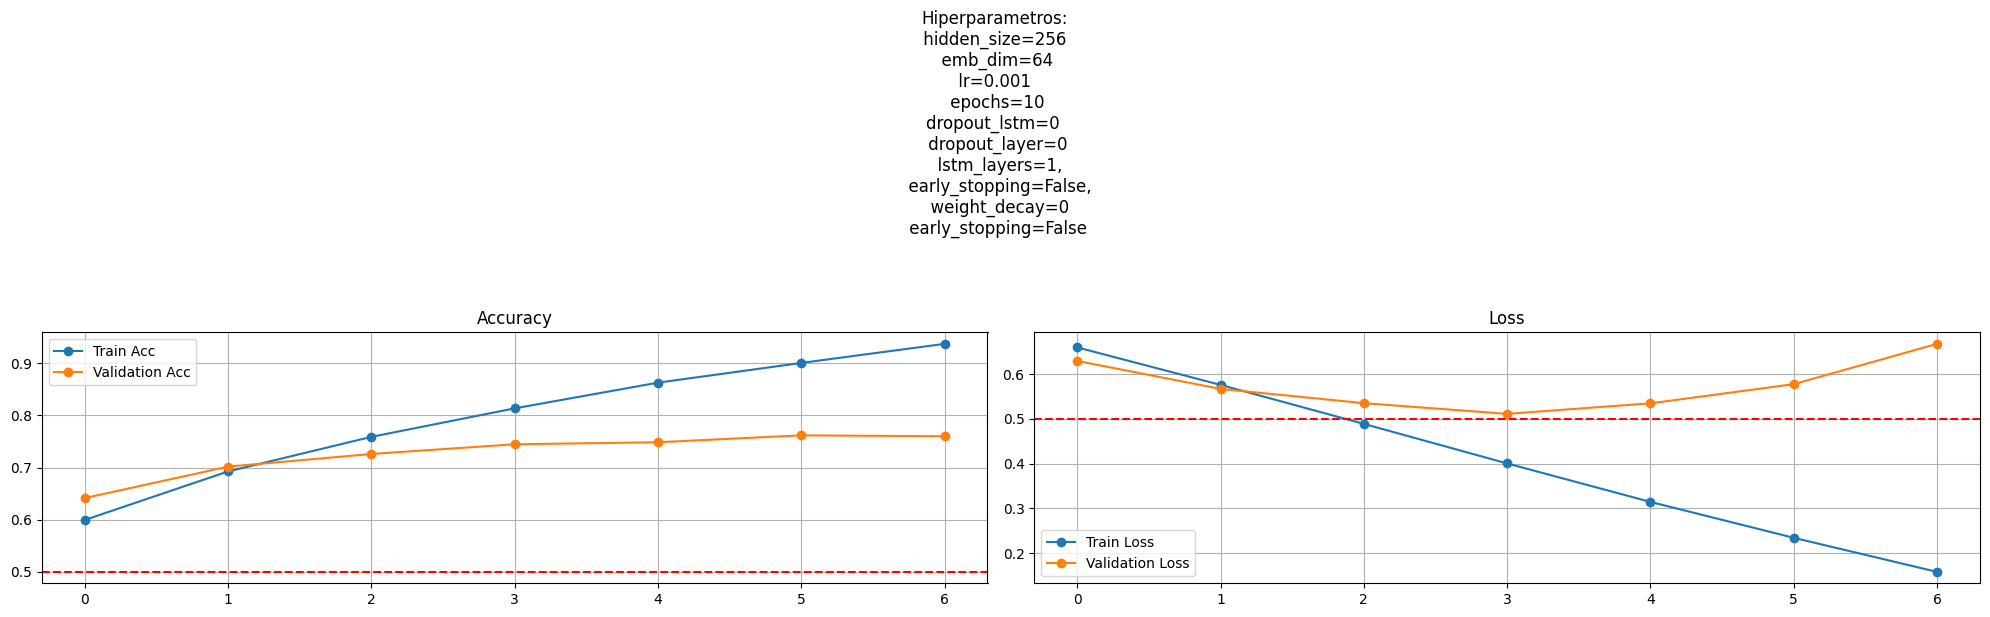

In [56]:
learning_curves_plot(basem_epoch_tr_acc,basem_epoch_vl_acc,basem_epoch_tr_loss,basem_epoch_vl_loss,dict_params)

hidden_size= 64, 
 emb_dim= 128, 
 lr= 0.0005, 
 epochs= 25, 
 drop_lstm= 0.4, 
 drop_layer= 0.4, 
 n_layers= 3, 
 weight_decay= 0.001, 
 early_stopping= True
SarcasmRNN(
  (embedding): Embedding(23574, 128)
  (lstm): LSTM(128, 64, num_layers=3, batch_first=True, dropout=0.4)
  (dropout): Dropout(p=0.4, inplace=False)
  (linear): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Número total de parámetros entrenables: 3133761


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 1
train_loss : 0.6837389180737157 val_loss : 0.6832961759396962
train_accuracy : 0.5522627581042046 val_accuracy : 0.5500624665357844
Validation loss decreased (inf --> 0.683296).  Saving model ...
epochs_count: 0


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 2
train_loss : 0.6603332302903616 val_loss : 0.654236593416759
train_accuracy : 0.6044720231090189 val_accuracy : 0.6178832768159914
Validation loss decreased (0.683296 --> 0.654237).  Saving model ...
epochs_count: 0


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 3
train_loss : 0.6265659953958245 val_loss : 0.62680698292596
train_accuracy : 0.6487643094040869 val_accuracy : 0.6507228270569337
Validation loss decreased (0.654237 --> 0.626807).  Saving model ...
epochs_count: 0


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 4
train_loss : 0.6033105760492304 val_loss : 0.5976920574903488
train_accuracy : 0.6736920937199101 val_accuracy : 0.677315723719436
Validation loss decreased (0.626807 --> 0.597692).  Saving model ...
epochs_count: 0


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 5
train_loss : 0.5671232070333214 val_loss : 0.5584528520703316
train_accuracy : 0.7031132983845084 val_accuracy : 0.7078350883455292
Validation loss decreased (0.597692 --> 0.558453).  Saving model ...
epochs_count: 0


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 6
train_loss : 0.5157326940567263 val_loss : 0.5442243005548205
train_accuracy : 0.7422702471381192 val_accuracy : 0.7119400321256469
Validation loss decreased (0.558453 --> 0.544224).  Saving model ...
epochs_count: 0


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 7
train_loss : 0.47907474957486634 val_loss : 0.5254729996834483
train_accuracy : 0.7636674868941906 val_accuracy : 0.7299660895948599
Validation loss decreased (0.544224 --> 0.525473).  Saving model ...
epochs_count: 0


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 8
train_loss : 0.44377196508069194 val_loss : 0.5170079852853503
train_accuracy : 0.789504653899647 val_accuracy : 0.740139211136891
Validation loss decreased (0.525473 --> 0.517008).  Saving model ...
epochs_count: 0


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 9
train_loss : 0.4162677459178432 val_loss : 0.5213473609515599
train_accuracy : 0.8046966941264577 val_accuracy : 0.7447795823665894
epochs_count: 1


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 10
train_loss : 0.39630671534486994 val_loss : 0.519726924598217
train_accuracy : 0.8180699689740023 val_accuracy : 0.7456719614492237
epochs_count: 2


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 11
train_loss : 0.37835077797212907 val_loss : 0.531884026314531
train_accuracy : 0.8272172889697229 val_accuracy : 0.7421024451186864
epochs_count: 3
epochs_count: 3
Early stopping triggered after 3 epochs.


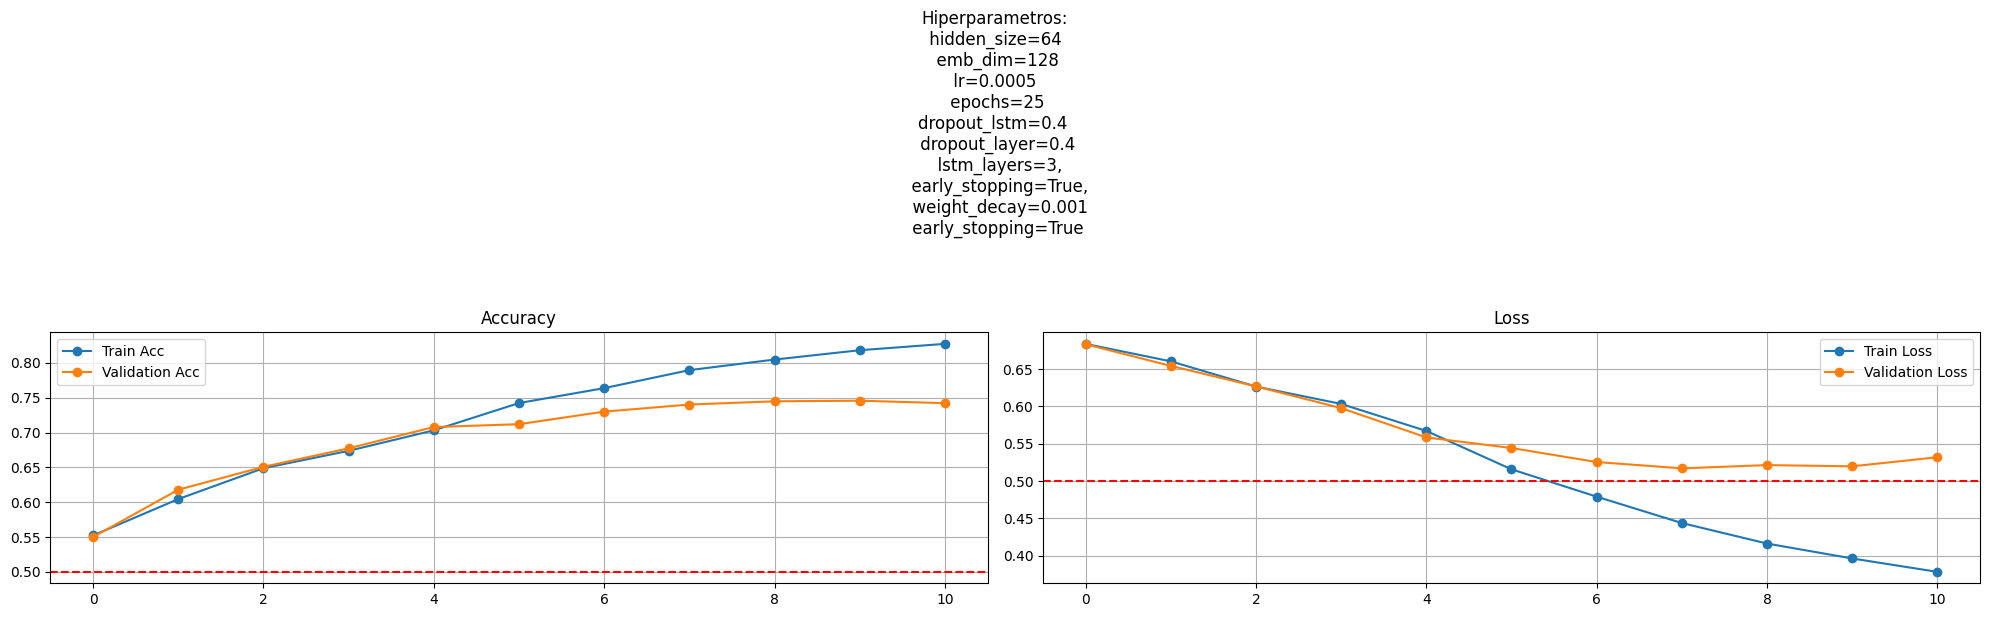

In [57]:
vocab_size = len(mapping_word_to_int_dict)+1 # +1 for the 0 padding + our word tokens
output_size = 1

# # Búsqueda de hiperparámetros manual
# hidden_size = 50 #[32, 64, 128, 256]
# embedding_dim = 100 # [50, 100]
# learning_rates = 1e-5 # [0.0001, 0.001]
# num_epochs = [ 25, 50] #[25, 50,100]
# gradient_clip = None # [None, 5, 20]
# dropout_lstm = 0.5 #, [0.3,0.5]
# dropout_layer = 0.5 # [0.3,0.5]
# n_layers = [2, 5]
# early_stopping = True
# weight_decay = 1e-5 #[0,1e-5]

# HIPER PARAMETROS PROPUESTOS POR GPT PARA SOBRE AJUSTE

# hidden_size = 128
# embedding_dim = 128
# learning_rates = 0.0005
# num_epochs = [25]
# gradient_clip = None
# dropout_lstm = 0.2
# dropout_layer = 0.2
# n_layers = [2]
# early_stopping = True
# weight_decay = 0.0001


# Segunda prueba con HIperparametros de GPT

# hidden_size = 64
# embedding_dim = 128
# learning_rates = 0.0005
# num_epochs = [25]
# gradient_clip = None
# dropout_lstm = 0.4
# dropout_layer = 0.4
# n_layers = [1]
# early_stopping = True
# weight_decay = 0.001


# Segunda prueba con HIperparametros de GPT

hidden_size = 64
embedding_dim = 128
learning_rates = 0.0005
num_epochs = [25]
gradient_clip = None
dropout_lstm = 0.4
dropout_layer = 0.4
n_layers = [3]
early_stopping = True
weight_decay = 0.001

# En esta iteración solo haremos búsqueda de valores con respecto al número de capas y al número de epochs
for layers in n_layers:
  for epochs in num_epochs:
        dict_params= {}
        dict_params['hidden_size'] = hidden_size
        dict_params['emb_dim']= embedding_dim
        dict_params['lr']= learning_rates
        dict_params['epochs']= epochs
        dict_params['dropout_lstm']=dropout_lstm
        dict_params['dropout_layer']=dropout_layer
        dict_params['lstm_layers']= layers
        dict_params['weight_decay']= weight_decay
        dict_params['early_stopping']=early_stopping
        print(f'hidden_size= {hidden_size}, \n emb_dim= {embedding_dim}, \n lr= {learning_rates}, \n epochs= {epochs}, \n drop_lstm= {dropout_lstm}, \n drop_layer= {dropout_layer}, \n n_layers= {layers}, \n weight_decay= {weight_decay}, \n early_stopping= {early_stopping}')
        model= SarcasmRNN(vocab_size=vocab_size,
          output_size=output_size,
          embedding_dim=embedding_dim,
          hidden_dim=hidden_size,
          n_layers=layers,
          dropout_lstm=dropout_lstm,
          dropout_layer = dropout_layer)
        print(model)
        num_params = count_parameters(model)
        print(f'Número total de parámetros entrenables: {num_params}')
        model.to(device)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rates,weight_decay=weight_decay) # CAMBIE ADAM POR ADAMW
        m_epoch_tr_acc, m_epoch_vl_acc, m_epoch_tr_loss, m_epoch_vl_loss = training_model(model,
              train_loader,
              valid_loader,
              n_epochs=epochs,
              criterion=criterion,
              acc=acc,
              batch_size=batch_size,
              gradient_clip= gradient_clip,
              early_stopping=early_stopping,
              optimizer = optimizer
              )
        learning_curves_plot(m_epoch_tr_acc,m_epoch_vl_acc,m_epoch_tr_loss,m_epoch_vl_loss,dict_params)
        print('========================================================================================================')

In [58]:
# # HIPER PARAMETROS DE GPT

# vocab_size = len(mapping_word_to_int_dict)+1 # +1 for the 0 padding + our word tokens
# output_size = 1
# embedding_dim = 64
# hidden_dim = 256
# n_layers = 1
# epochs = 10
# gradient_clip= None

# # loss and optimization functions
# lr=0.001

# base_model2 = SarcasmRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

# #moving to gpu
# base_model.to(device)
# criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(base_model.parameters(), lr=lr)


# print(base_model)

In [59]:
# basem_epoch_tr_acc2, basem_epoch_vl_acc2, basem_epoch_tr_loss2, basem_epoch_vl_loss2 = training_model(base_model2,
#                      train_loader,
#                      valid_loader,
#                      n_epochs=epochs,
#                      criterion=criterion,
#                      acc=acc,
#                      batch_size=batch_size,
#                      optimizer=optimizer
#                      ,early_stopping=True)

In [60]:
# dict_params2= {}
# dict_params2['hidden_size'] = hidden_dim
# dict_params2['emb_dim']= embedding_dim
# dict_params2['lr']= lr
# dict_params2['epochs']= epochs
# dict_params2['dropout_lstm']=0
# dict_params2['dropout_layer']=0
# dict_params2['lstm_layers']= n_layers

In [61]:
#learning_curves_plot(basem_epoch_tr_acc2,basem_epoch_vl_acc2,basem_epoch_tr_loss2,basem_epoch_vl_loss2,dict_params2)

**MODELO CON GRU**

In [62]:
import torch
import torch.nn as nn

class SarcasmRNNGRU(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self,
                 vocab_size,
                 output_size,
                 embedding_dim,
                 hidden_dim,
                 n_layers,
                 dropout_gru=0,
                 dropout_layer=0):
        """
        Initialize the model by setting up the layers.
        """
        super(SarcasmRNNGRU, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size

        # embedding and GRU layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers,
                          dropout=dropout_gru, batch_first=True)  # dropout only applies if n_layers > 1
        # batch_first=True expects input of shape (batch_size, sequence_length, input_size)

        # dropout layer
        self.dropout = nn.Dropout(dropout_layer)

        # linear and sigmoid layers
        self.linear = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)  # Get the batch size

        # embeddings and gru_out
        x = x.long()  # The embedding layer expects long type inputs
        embeds = self.embedding(x)
        gru_out, hidden = self.gru(embeds, hidden)

        gru_out = gru_out[:, -1, :]  # Get the output from the last time step

        # dropout and fully-connected layer
        out = self.dropout(gru_out)
        out = self.linear(out)
        # sigmoid function
        sig_out = self.sigmoid(out)

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create a new tensor with size n_layers x batch_size x hidden_dim
        # initialized to zero, for the hidden state of the GRU
        h0 = torch.zeros((self.n_layers, batch_size, self.hidden_dim)).to(device)
        return h0


In [63]:
def training_model_gru(model,
                   train_loader,
                   valid_loader,
                   n_epochs,
                   criterion,
                   acc,
                   batch_size,
                   optimizer,
                   gradient_clip=None,
                   early_stopping: bool = False):

    clip = gradient_clip
    epochs = n_epochs
    valid_loss_min = np.Inf

    # epochs acc and loss
    epoch_tr_loss = []
    epoch_vl_loss = []
    epoch_tr_acc = []
    epoch_vl_acc = []

    # Early stopping
    if early_stopping:
        patience = 3  # Número de épocas hasta la detección
        epochs_count = 0

    for epoch in trange(epochs):
        model.train()
        train_losses = []
        train_acc = 0.0
        # initialize hidden state in zero (GRU only has one hidden state)
        hidden = model.init_hidden(batch_size)

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            model.zero_grad()  # Limpiamos los gradientes

            # Realizamos un paso hacia adelante
            hidden = hidden.data  # Actualizamos el hidden state en GRU (ya no es una tupla)
            output, hidden = model(inputs, hidden)

            # Calculamos la loss
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()

            train_losses.append(loss.item())

            # Calcular accuracy
            accuracy = acc(output, labels)
            train_acc += accuracy

            if clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_h = model.init_hidden(batch_size)
            val_losses = []
            val_acc = 0.0
            for inputs, labels in valid_loader:
                val_h = val_h.data  # Actualizamos el hidden state en GRU
                inputs, labels = inputs.to(device), labels.to(device)
                output, val_h = model(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())
                val_losses.append(val_loss.item())

                # Calcular accuracy
                accuracy = acc(output, labels)
                val_acc += accuracy

        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)

        epoch_train_acc = train_acc / len(train_loader.dataset)
        epoch_val_acc = val_acc / len(valid_loader.dataset)

        epoch_tr_loss.append(epoch_train_loss)
        epoch_vl_loss.append(epoch_val_loss)

        epoch_tr_acc.append(epoch_train_acc)
        epoch_vl_acc.append(epoch_val_acc)

        print(f'Epoch {epoch + 1}')
        print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
        print(f'train_accuracy : {epoch_train_acc} val_accuracy : {epoch_val_acc}')

        if epoch_val_loss <= valid_loss_min:
            torch.save(model.state_dict(), 'state_dict.pt')
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {epoch_val_loss:.6f}).  Saving model ...')
            valid_loss_min = epoch_val_loss
            if early_stopping:
                epochs_count = 0  # Reiniciar si el modelo mejora
                print(f'epochs_count: {epochs_count}')
        elif early_stopping:
            epochs_count += 1  # Incrementar si el modelo no mejora
            print(f'epochs_count: {epochs_count}')
        if early_stopping == True:
            if epochs_count >= patience:
                print(f'epochs_count: {epochs_count}')
                print(f'Early stopping triggered after {epochs_count} epochs.')
                break
        print(25 * '==')

    return epoch_tr_acc, epoch_vl_acc, epoch_tr_loss, epoch_vl_loss


In [64]:
# Hiperparámetros
vocab_size = len(mapping_word_to_int_dict) + 1  # +1 para incluir el padding y las palabras del vocabulario
output_size = 1  # Salida binaria (sarcasmo/no sarcasmo)
embedding_dim = 64  # Dimensión de los embeddings
hidden_dim = 256  # Dimensión del estado oculto
n_layers = 1  # Número de capas GRU
epochs = 10
gradient_clip = None  # Puedes ajustar esto si es necesario

# Tasa de aprendizaje para el optimizador
lr = 0.001

# Instanciación del modelo SarcasmRNN (ahora con GRU)
base_model_gru = SarcasmRNNGRU(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

# Mover el modelo a GPU (si está disponible)
base_model_gru.to(device)

# Definir la función de pérdida (Binary Cross-Entropy) y el optimizador (Adam)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(base_model_gru.parameters(), lr=lr)

# Verificación del modelo
print(base_model_gru)


SarcasmRNNGRU(
  (embedding): Embedding(23574, 64)
  (gru): GRU(64, 256, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [65]:
basem_epoch_tr_acc_gru, basem_epoch_vl_acc_gru, basem_epoch_tr_loss_gru, basem_epoch_vl_loss_gru = training_model_gru(base_model_gru,
                     train_loader,
                     valid_loader,
                     n_epochs=epochs,
                     criterion=criterion,
                     acc=acc,
                     batch_size=batch_size,
                     optimizer=optimizer,
                    early_stopping=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 1
train_loss : 0.6606979267571562 val_loss : 0.6332699975797108
train_accuracy : 0.5934524446346421 val_accuracy : 0.6410851329644833
Validation loss decreased (inf --> 0.633270).  Saving model ...
epochs_count: 0


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 2
train_loss : 0.5747284379697615 val_loss : 0.5845793804952076
train_accuracy : 0.6878142719589173 val_accuracy : 0.6908798857754774
Validation loss decreased (0.633270 --> 0.584579).  Saving model ...
epochs_count: 0


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 3
train_loss : 0.4909403596514015 val_loss : 0.5486757861716407
train_accuracy : 0.7540387290039585 val_accuracy : 0.7192575406032483
Validation loss decreased (0.584579 --> 0.548676).  Saving model ...
epochs_count: 0


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 4
train_loss : 0.40794789983380225 val_loss : 0.5310667955449649
train_accuracy : 0.8076923076923077 val_accuracy : 0.7367481706228806
Validation loss decreased (0.548676 --> 0.531067).  Saving model ...
epochs_count: 0


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 5
train_loss : 0.32324448596405725 val_loss : 0.5565670281648636
train_accuracy : 0.8536963731678614 val_accuracy : 0.7451365339996431
epochs_count: 1


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 6
train_loss : 0.2402863166024608 val_loss : 0.5946624694125993
train_accuracy : 0.8966513319781748 val_accuracy : 0.7519186150276638
epochs_count: 2


  0%|          | 0/93 [00:00<?, ?it/s]

Epoch 7
train_loss : 0.15254696306361948 val_loss : 0.706242995602744
train_accuracy : 0.9360222531293463 val_accuracy : 0.7549527039086203
epochs_count: 3
epochs_count: 3
Early stopping triggered after 3 epochs.


In [66]:
dict_params_gru = {}
dict_params_gru['hidden_size'] = hidden_dim  # Dimensión del estado oculto
dict_params_gru['emb_dim'] = embedding_dim  # Dimensión del embedding
dict_params_gru['lr'] = lr  # Tasa de aprendizaje
dict_params_gru['epochs'] = epochs  # Número de épocas
dict_params_gru['dropout_gru'] = 0  # Dropout para las capas GRU
dict_params_gru['dropout_layer'] = 0  # Dropout antes de la capa fully connected
dict_params_gru['gru_layers'] = n_layers  # Número de capas GRU

In [67]:
def learning_curves_plot_gru(epoch_tr_acc,
                         epoch_vl_acc,
                         epoch_tr_loss,
                         epoch_vl_loss,
                         dict_params):
    ## Get the values of hyperparameters from dict_params
    hidden_size = dict_params['hidden_size']
    emb_dim = dict_params['emb_dim']
    lr = dict_params['lr']
    epochs = dict_params['epochs']
    dropout_lstm = dict_params.get('dropout_lstm',0)
    dropout_layer = dict_params.get('dropout_layer',0)
    weight_decay = dict_params.get('weight_decay',0)
    gru_layers = dict_params['gru_layers']
    early_stopping = dict_params.get('early_stopping',False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    # Plot accuracy
    ax1.plot(epoch_tr_acc, label='Train Acc',marker='o')
    ax1.plot(epoch_vl_acc, label='Validation Acc',marker='o')
    ax1.axhline(y=0.5, color='r', linestyle='--')  # Línea horizontal en y=0.5
    ax1.set_title("Accuracy")
    ax1.legend()
    ax1.grid()

    # Plot loss
    ax2.plot(epoch_tr_loss, label='Train Loss', marker='o')
    ax2.plot(epoch_vl_loss, label='Validation Loss',marker='o')
    ax2.axhline(y=0.5, color='r', linestyle='--')  # Línea horizontal en y=0.5
    ax2.set_title("Loss")
    ax2.legend()
    ax2.grid()
    plt.suptitle(f'Hiperparametros:\n hidden_size={hidden_size} \n  emb_dim={emb_dim} \n lr={lr} \n epochs={epochs}\n'
                 f'dropout_lstm={dropout_lstm} \n dropout_layer={dropout_layer}\n  lstm_layers={gru_layers},\n  early_stopping={early_stopping},\n  weight_decay={weight_decay}'
                 f'\n early_stopping={early_stopping}',
                 fontsize=12, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Acomodar automáticamente los gráficos y el título
    plt.show()
    return None

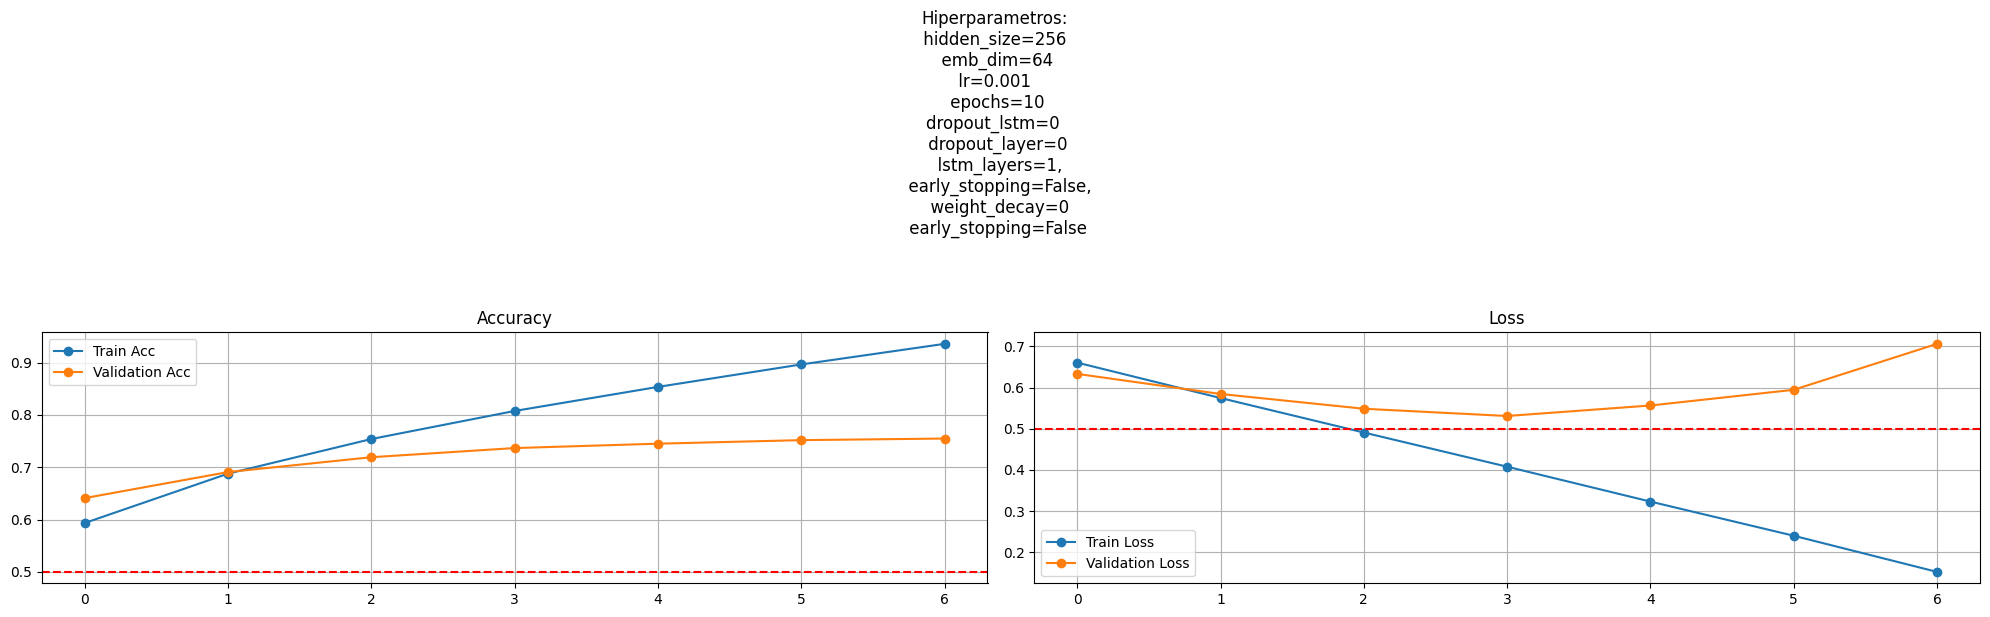

In [68]:
learning_curves_plot_gru(basem_epoch_tr_acc_gru,basem_epoch_vl_acc_gru,basem_epoch_tr_loss_gru,basem_epoch_vl_loss_gru,dict_params_gru)